# Greedy Algorithm

In [1]:
from graphs_2d import *

networkx.classes.graph.Graph

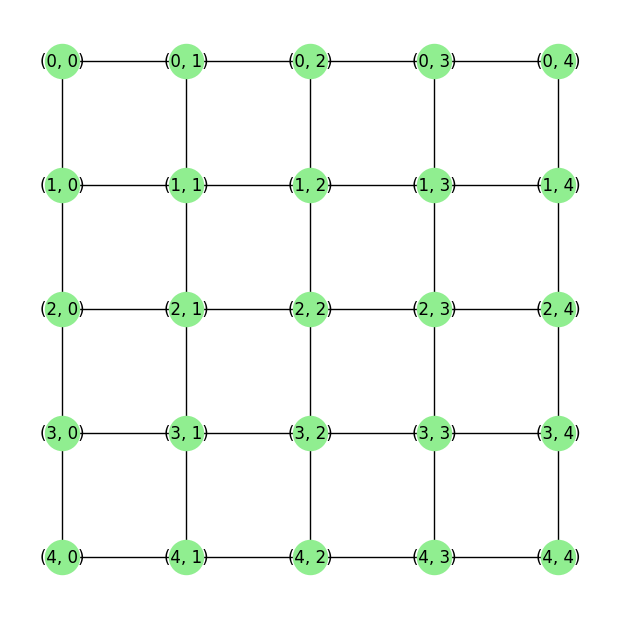

In [2]:
# Generate a single graph
rows, cols = 5, 5
grid_graph = generate_2D_grid_graph(rows, cols)
adjacency_matrix = nx.adjacency_matrix(grid_graph).todense()

plot_graph(grid_graph)

type(grid_graph)

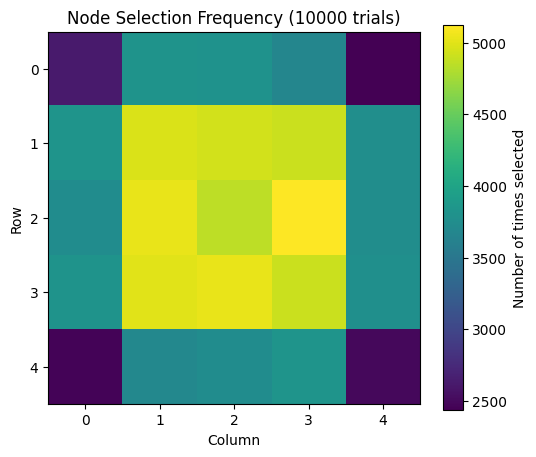

In [3]:
# Run the selection 10000 times
counts = np.zeros(len(grid_graph.nodes()))
for _ in range(100000):
    node = select_starting_node_8way_probablistic(grid_graph)
    node_index = list(grid_graph.nodes()).index(node)
    counts[node_index] += 1

# Reshape counts to match the grid for visualization
counts_matrix = counts.reshape((rows, cols))

plt.figure(figsize=(6, 5))
plt.imshow(counts_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Number of times selected')
plt.title('Node Selection Frequency (10000 trials)')
plt.xlabel('Column')
plt.ylabel('Row')
plt.show()

In [4]:
# Run the selection 10000 times
counts = np.zeros(len(grid_graph.nodes()))
for _ in range(100000):
    node = select_starting_node_max_neighbors(grid_graph)
    node_index = list(grid_graph.nodes()).index(node)
    counts[node_index] += 1

# Reshape counts to match the grid for visualization
counts_matrix = counts.reshape((rows, cols))

plt.figure(figsize=(6, 5))
plt.imshow(counts_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Number of times selected')
plt.title('Node Selection Frequency (10000 trials)')
plt.xlabel('Column')
plt.ylabel('Row')
plt.show()

NameError: name 'select_starting_node_max_neighbors' is not defined